In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from math import sqrt

# Analyzing My Facebook Friend History

In [2]:
df = pd.read_json('friends/friends.json')

In [3]:
df_new = pd.DataFrame(df['friends'].values.tolist())
df_new['name'] = df_new['name'].astype('category').cat.codes

In [4]:
df_new.sort_values('timestamp')

,name,timestamp,contact_info
1594,778,1311645691,NaN
1593,1150,1311645693,NaN
1592,78,1311645694,NaN
1591,93,1311646591,NaN
1590,1012,1311646604,NaN
...,...,...,...
4,1422,1618850085,NaN
3,715,1618867441,NaN
2,1409,1620010626,NaN
1,506,1620526037,NaN


In [5]:
df_new['date'] = pd.to_datetime(df_new['timestamp'], unit='s')

In [6]:
df_new['year'] = df_new['date'].dt.to_period('Y')

In [7]:
df_new['month'] = df_new['date'].dt.to_period('M')

In [8]:
fpm = df_new.groupby('month').count()['name']

What does my friend history look like if we count how many new friends I add per month?

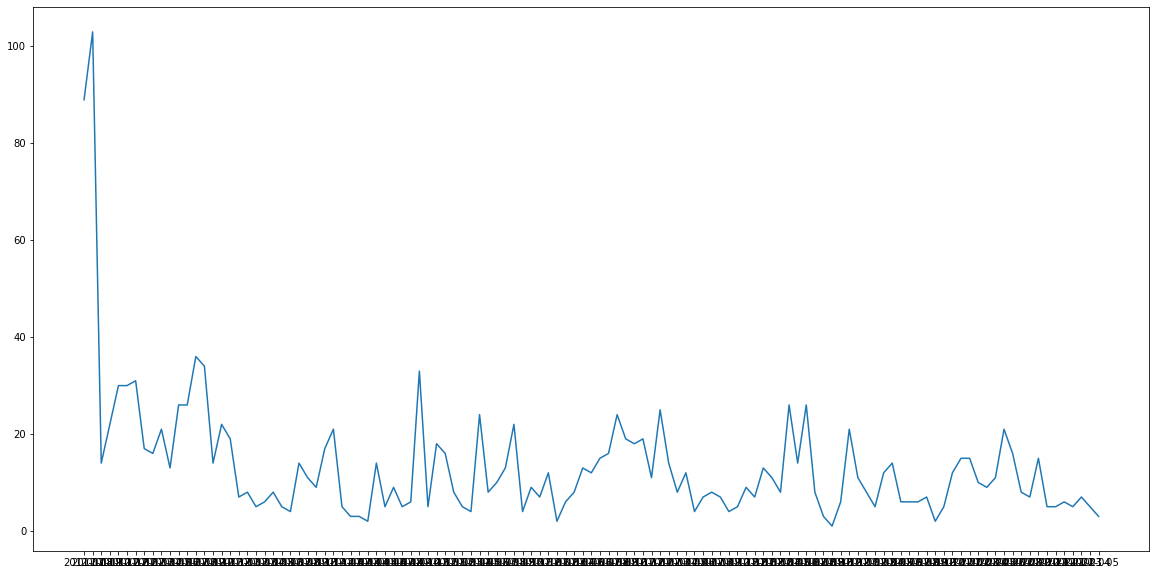

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpm.index.astype(str), fpm)
plt.show()

Let's see if we can fit an SARIMAX model to this time series data!

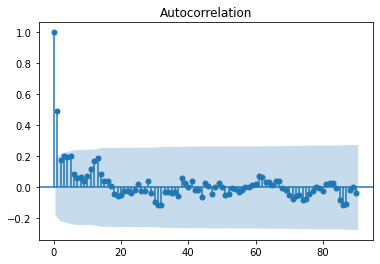

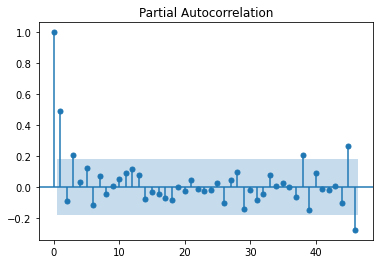

In [10]:
plot_acf(fpm,lags=90) 
plt.show()
plot_pacf(fpm,lags=46) 
plt.show()

From the ACF/PACF plots, we can see this data is stationary. Let's back it up with an ADF test.

In [11]:
dftest = adfuller(fpm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.749897
p-value           0.003464
dtype: float64


This is stationary!

In [12]:
# define all the functions we will need -- these are from my Time Series class in my Masters program

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing: interval=1
#seasonal differencing: interval=m


#grid order search based on BIC
#auto-arima order selection in pmdarima
#python -m pip install pmdarima doesn't work for my python 3.9 anymore, so I wrote one

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic=res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))
    
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

Let's use BIC to find the best parameters for our SARIMAX model.

In [13]:
# m_values=[6]
# p_values=[0,1,2,3]
# q_values=[0,1,2,3]
# Q_values=[0,1,2,3]
# P_values=[0,1,2,3]

# bic_sarima(fpm, p_values,[0],q_values,P_values,Q_values,m_values, D=1)

That was slow and gave us this output:

(634.7457714493858, (0, 0, 3), (0, 1, 3, 6))

In [14]:
valid = df_new[df_new['year'].dt.year >= 2020]
history = df_new[df_new['year'].dt.year < 2020]

In [15]:
valid = valid.groupby('month').count()['name']
history = history.groupby('month').count()['name']

In [16]:
history.index = history.index.strftime('%Y-%m')
valid.index = valid.index.strftime('%Y-%m')

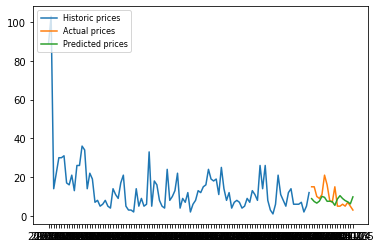

In [17]:
mod = sm.tsa.statespace.SARIMAX(history ,order=(0,0,3),seasonal_order=(0,1,3,6))
res = mod.fit()
pred=res.predict(start=len(history), end=len(history)+len(valid)-1)
valid = pd.DataFrame(valid)
valid['pred_friends'] = pred.values
plt.plot(history,label='Historic prices')

plt.plot(valid['name'],label='Actual prices')

plt.plot(valid['pred_friends'],label='Predicted prices')
plt.legend(loc='upper left', fontsize=8)
plt.show()

We do an ok job! I think it will be hard to get a great model in this particular case because the year 2020 coinsides with both the corona virus pandemic and this alterted my friend patterns. 

In [18]:
valid

,name,pred_friends
month,,
2020-01,15,8.888244
2020-02,15,7.396185
2020-03,10,6.576309
2020-04,9,7.595416
2020-05,11,10.043754
2020-06,21,9.559731
2020-07,16,7.508367
2020-08,8,7.556259
2020-09,7,7.322958


In [19]:
sqrt(mean_absolute_error(valid['name'], pred))

2.071188623413637

On average, our prediction was off by about two friends, that seems pretty good to me!

It would be interesting to see if these peaks (esepecially when I was younger) correlate to summer camp.

Could also show peaks correalte to new schools?

What about just yearly trends?

In [20]:
fpm = df_new.groupby('year').count()['name']

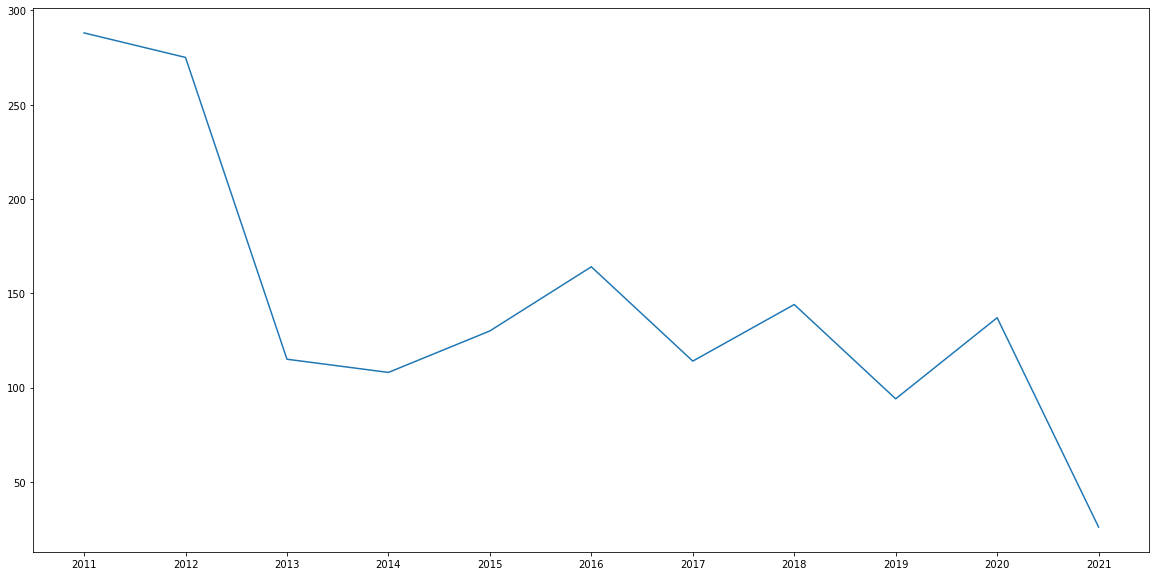

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpm.index.astype(str), fpm)
plt.show()

In [22]:
# m_values=[2]
# p_values=[0,1,2,3]
# q_values=[0,1,2,3]
# Q_values=[0,1,2,3]
# P_values=[0,1,2,3]

# bic_sarima(fpm, p_values,[0],q_values,P_values,Q_values,m_values, D=1)

That was somewhat slow and gave us this output:

(-58.55080630604138, (0, 0, 0), (3, 1, 0, 2))


In [23]:
valid = df_new[df_new['year'].dt.year >= 2018]
history = df_new[df_new['year'].dt.year < 2018]

In [24]:
valid = valid.groupby('year').count()['name']
history = history.groupby('year').count()['name']

In [25]:
history.index = history.index.strftime('%Y')
valid.index = valid.index.strftime('%Y')

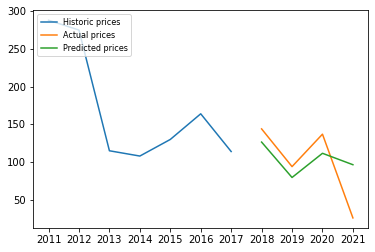

In [26]:
mod = sm.tsa.statespace.SARIMAX(history ,order=(0,0,0),seasonal_order=(3,1,0,2))
res = mod.fit()
pred=res.predict(start=len(history), end=len(history)+len(valid)-1)
valid = pd.DataFrame(valid)
valid['pred_friends'] = pred.values
plt.plot(history,label='Historic prices')

plt.plot(valid['name'],label='Actual prices')

plt.plot(valid['pred_friends'],label='Predicted prices')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [27]:
valid

,name,pred_friends
year,,
2018,144,126.513844
2019,94,79.588673
2020,137,111.650215
2021,26,96.515505


In [28]:
sqrt(mean_absolute_error(valid['name'], pred))

5.651609793994643

Does really well except for where I stopped adding as many people. Again, most likely due to covid? Only off by, on average, about five people per year! 

In [29]:
df_new['year'] = df_new['date'].dt.to_period('Y')

In [30]:
df_new['month'] = df_new['date'].dt.to_period('M')

In [31]:
mon = df_new.groupby('month').count()['name']

In [32]:
mfp = mon.rolling(window=3, center=True).mean()
mfp = mfp[~mfp.isna()]

Let's vizualize what was happening in my life when I added freinds on Facebook!

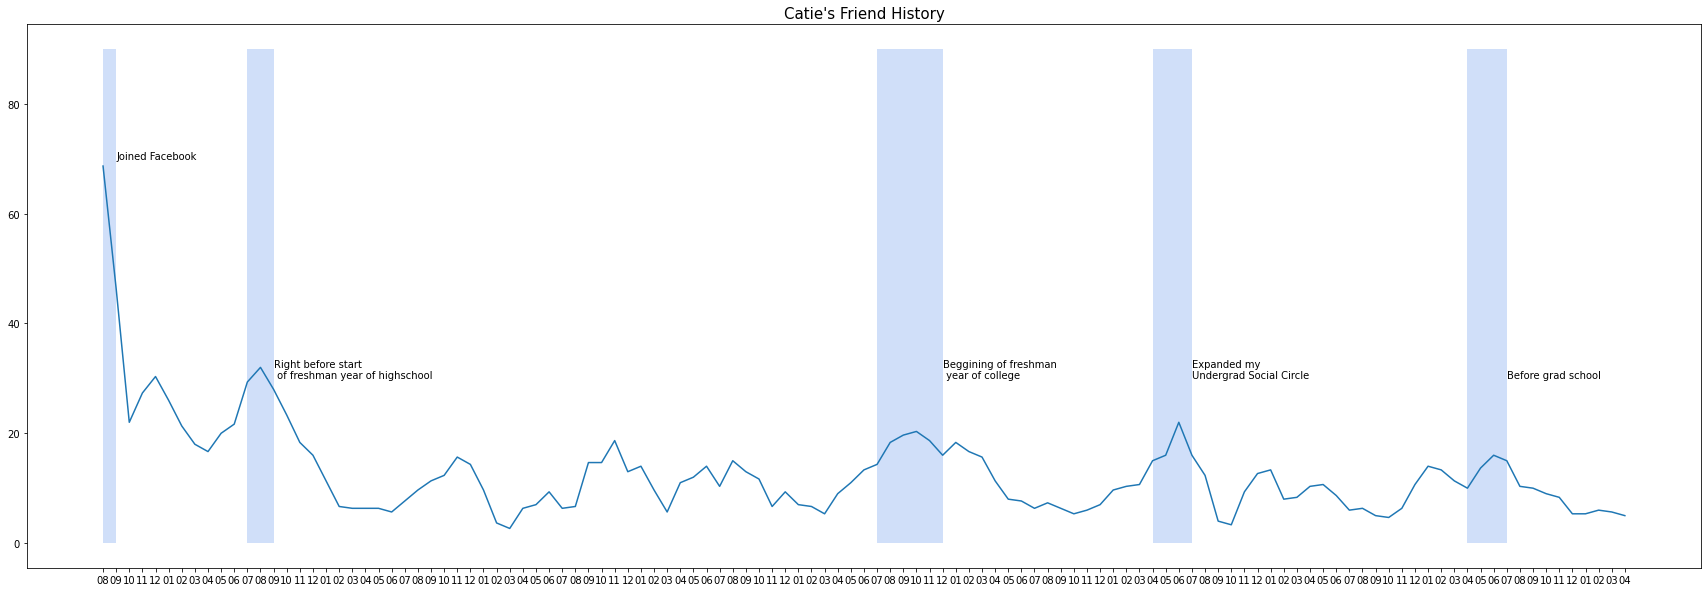

In [51]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(mfp.index.astype(str), mfp)
ax.set_xticklabels([item[-2:] for item in mfp.index.astype(str)])
rect = patches.Rectangle(xy=(0,0), width=1, height=90,
                         facecolor='cornflowerblue', alpha=.3)
ax.add_patch(rect)
rect2 = patches.Rectangle(xy=(11,0), width=2, height=90,
                         facecolor='cornflowerblue', alpha=.3)
ax.add_patch(rect2)
rect3 = patches.Rectangle(xy=(59,0), width=5, height=90,
                         facecolor='cornflowerblue', alpha=.3)
ax.add_patch(rect3)
rect4 = patches.Rectangle(xy=(104,0), width=3, height=90,
                         facecolor='cornflowerblue', alpha=.3)
ax.add_patch(rect4)
rect5 = patches.Rectangle(xy=(80,0), width=3, height=90,
                         facecolor='cornflowerblue', alpha=.3)
ax.add_patch(rect5)

ax.text(1,70, 'Joined Facebook')
ax.text(13 ,30, 'Right before start\n of freshman year of highschool')
ax.text(64 ,30, 'Beggining of freshman\n year of college')
ax.text(107 ,30, 'Before grad school')
ax.text(83 ,30, 'Expanded my \nUndergrad Social Circle')

plt.title('Catie\'s Friend History', fontsize=15)
plt.show()

Thanks for haning out :) 